<a href="https://colab.research.google.com/github/TheDandyCodes/CNN_Notes/blob/main/Ejercicio_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

Realizaremos un ejercicio descrito en el blog www.aprendemachinelearning.com para hacer reconocimiento de imágenes.

In [3]:
!wget https://github.com/jbagnato/machine-learning/raw/master/sportimages.zip

--2024-10-28 19:46:48--  https://github.com/jbagnato/machine-learning/raw/master/sportimages.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jbagnato/machine-learning/master/sportimages.zip [following]
--2024-10-28 19:46:49--  https://raw.githubusercontent.com/jbagnato/machine-learning/master/sportimages.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62780277 (60M) [application/zip]
Saving to: ‘sportimages.zip.1’

sportimages.zip.1   100%[===================>]  59.87M   307MB/s    in 0.2s    

2024-10-28 19:46:49 (307 MB/s) - ‘sportimages.zip.1’ saved [62780277/62780277]



In [4]:
# prompt: unzip un .zip

!unzip sportimages.zip


Archive:  sportimages.zip
replace sportimages/golf/golf_0690.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Importar Librerías

In [5]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
!pip install keras

In [23]:
# Instead of importing from keras.layers.normalization:
# from keras.layers.normalization import BatchNormalization

# Import BatchNormalization directly from keras.layers:
from keras.layers import BatchNormalization, LeakyReLU
from keras.utils import to_categorical
from keras import Sequential, Model
from tensorflow.keras import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Cargar set de Imágenes

In [9]:
dirname = os.path.join(os.getcwd(), 'sportimages')
imgpath = dirname + os.sep

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /content/sportimages/
/content/sportimages/tenis 1
/content/sportimages/beisball 8937
/content/sportimages/futbol 7752
/content/sportimages/natacion 7617
/content/sportimages/f1 5172
/content/sportimages/boxeo 5053
/content/sportimages/ciclismo 7125
/content/sportimages/golf 7533
/content/sportimages/basket 9768
/content/sportimages/americano 8823
Directorios leidos: 10
Imagenes en cada directorio [8938, 7752, 7617, 5172, 5053, 7125, 7533, 9768, 8823, 9347]
suma Total de imagenes en subdirs: 77128


# Creamos las etiquetas

In [10]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  77128


In [11]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 tenis
1 beisball
2 futbol
3 natacion
4 f1
5 boxeo
6 ciclismo
7 golf
8 basket
9 americano


In [12]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


# Creamos Sets de Entrenamiento y Test

In [13]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (61702, 21, 28, 3) (61702,)
Testing data shape :  (15426, 21, 28, 3) (15426,)


Text(0.5, 1.0, 'Ground Truth : 5')

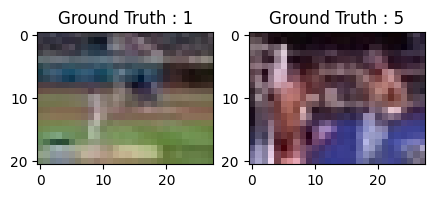

In [14]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

In [1]:
import tensorflow as tf
assert tf.__version__>="2.0"
gpus_list = tf.config.list_physical_devices('GPU')
if not gpus_list:
  print('No GPUs detected')
else:
  print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Preprocesamos las imagenes

In [15]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

## Hacemos el One-hot Encoding para la red

In [16]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 1
After conversion to one-hot: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [17]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [18]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


# Creamos el modelo de CNN

In [19]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 6 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [20]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

NameError: name 'Conv2D' is not defined

In [ ]:
sport_model.summary()

In [ ]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [ ]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
# como ejemplo, en mi Macbook pro tarda 4 minutos
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

In [ ]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sports_mnist.h5py")

# Evaluamos la red

In [ ]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [ ]:
accuracy = sport_train.history['acc']
val_accuracy = sport_train.history['val_acc']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
predicted_classes2 = sport_model.predict(test_X)

In [ ]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [ ]:
predicted_classes.shape, test_Y.shape

# Aprendamos de los errores: Qué mejorar

In [ ]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

In [ ]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [ ]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

# Prediccion de una nueva imagen

In [ ]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['test/golf_0113.jpg']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (21, 28),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])